참고 자료

- https://pytorch.org/tutorials/beginner/pytorch_with_examples.html     
- https://github.com/pytorch/examples

# 오토인코더 기반 생성 모델
## VAE (Variational Autoencoder)

2013년 Kingma와 Welling에 의해 소개되었습니다. https://arxiv.org/pdf/1312.6114

VAE는 주로 잠재 공간에서의 확률적 표현과 데이터 생성을 목적으로 하고 있습니다.


1. 확률적 모델:   
일반적인 오토인코더와 달리, VAE는 잠재 공간에서 고정된 값이 아닌 확률 분포를 학습합니다. 잠재 공간에서 특정 지점이 아닌 가우시안 분포를 사용해 다양한 샘플을 생성합니다.

1. 잠재 공간의 연속성:   
VAE는 잠재 공간(latent space)을 연속적이고 부드럽게 학습하여, 이 공간에서 샘플링한 값들이 자연스럽게 데이터를 생성할 수 있도록 합니다. 이로 인해 새로운 데이터를 쉽게 생성할 수 있습니다.

1. Reparameterization Trick (재파라미터화 기법):   
VAE는 모델이 학습할 수 있도록 재파라미터화 기법을 사용합니다. 이는 확률 분포에서 샘플링을 할 때 미분 가능하게 처리하기 위한 기술입니다.

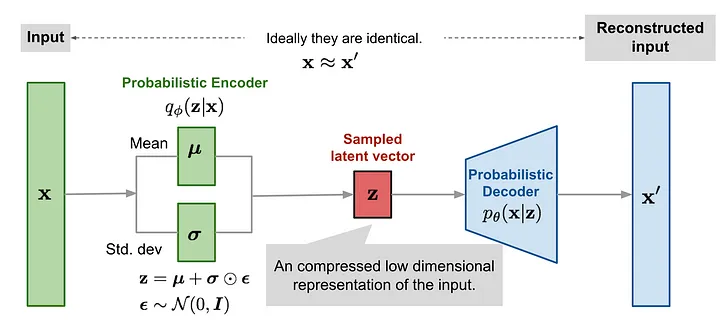

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print("Using PyTorch version:", torch.__version__,' Device:', DEVICE)

BATCH_SIZE = 1024

Using PyTorch version: 2.3.0+cu121  Device: cuda


In [ ]:
from torchvision import transforms, datasets
train_dataset = datasets.MNIST(root = "./data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "./data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder layers (4 layers)
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_mu = nn.Linear(128, latent_dim)  # mean
        self.fc_logvar = nn.Linear(128, latent_dim)  # log variance

        # Decoder layers (4 layers)
        self.fc5 = nn.Linear(latent_dim, 128)
        self.fc6 = nn.Linear(128, 256)
        self.fc7 = nn.Linear(256, 512)
        self.fc8 = nn.Linear(512, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        return self.fc_mu(h3), self.fc_logvar(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h5 = F.relu(self.fc5(z))
        h6 = F.relu(self.fc6(h5))
        h7 = F.relu(self.fc7(h6))
        return torch.sigmoid(self.fc8(h7))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
model = VAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# criterion = nn.CrossEntropyLoss()

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
from tqdm import tqdm
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [ ]:
from torchvision.utils import save_image
for epoch in range(1, 40):
    train(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).cuda()
        sample = model.decode(sample).cpu()
        if epoch % 5 == 0:
            save_image(sample.view(64, 1, 28, 28),
                       'vae_results/sample_' + str(epoch) + '.png')

https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html

0it [00:00, ?it/s]

59it [00:05, 10.10it/s]


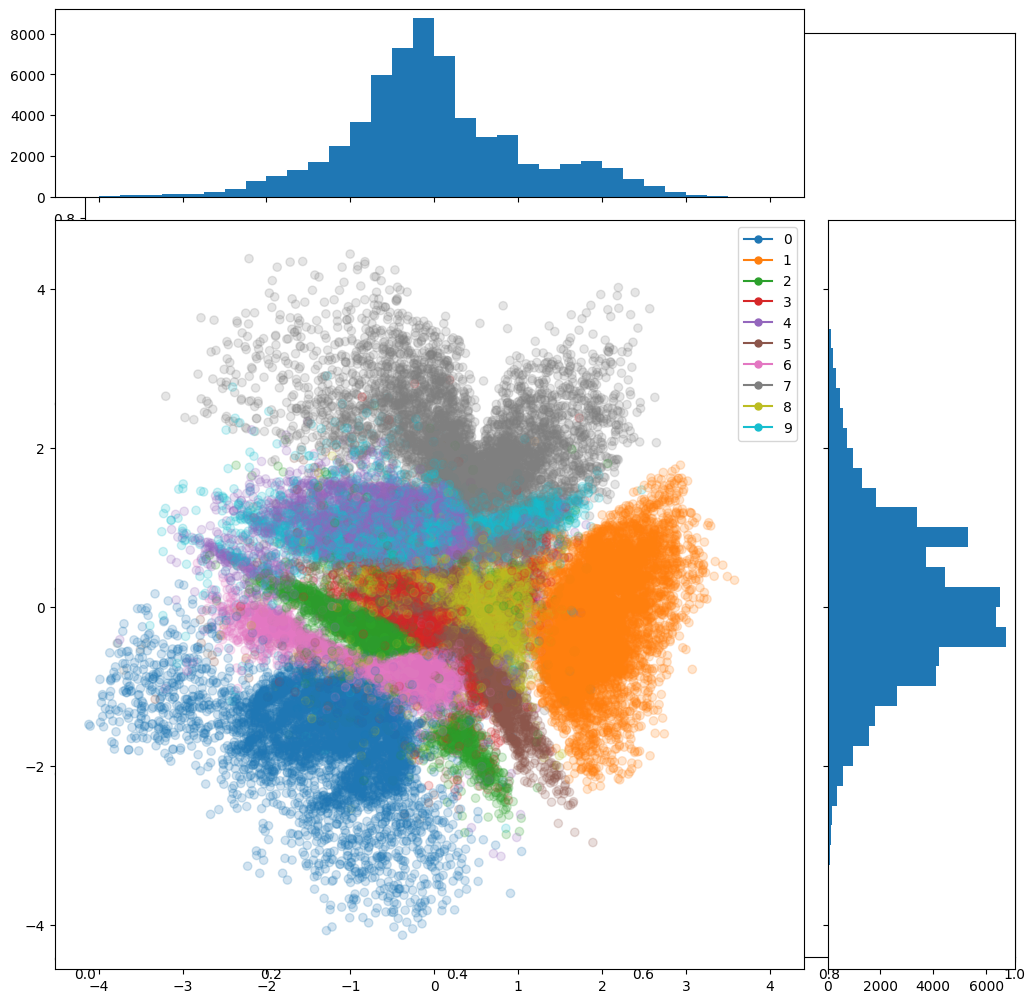

In [ ]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color=f'C{c}', label=f'{c}',
                    markerfacecolor=f'C{c}', markersize=5) for c in range(10)]

fig, ax = plt.subplots(figsize=(12, 12))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])

model.eval()
mu_x =[]
mu_y = []
for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
    mu, _ = model.encode(image.view(-1, 28*28).to(DEVICE))
    mu = mu.cpu().detach().numpy()

    mu_x.extend(mu[:, 0])
    mu_y.extend(mu[:, 1])

    label_cmap = [f'C{l}' for l in label]
    ax.scatter(mu[:, 0], mu[:, 1], c = label_cmap, alpha = 0.2)

plt.legend(handles = legend_elements)

ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# now determine nice limits by hand:
binwidth = 0.25
# xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
# lim = (int(xymax/binwidth) + 1) * binwidth
lim = 4
bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(mu_x, bins=bins)
ax_histy.hist(mu_y, bins=bins, orientation='horizontal')

plt.show()

In [ ]:
class VAE_W_CLS(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE_W_CLS, self).__init__()

        # Encoder layers (4 layers)
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc41 = nn.Linear(128, latent_dim)  # mean
        self.fc42 = nn.Linear(128, latent_dim)  # log variance

        # Decoder layers (4 layers)
        self.fc5 = nn.Linear(latent_dim, 128)
        self.fc6 = nn.Linear(128, 256)
        self.fc7 = nn.Linear(256, 512)
        self.fc8 = nn.Linear(512, 784)

        self.cls1 = nn.Linear(latent_dim, 16)
        self.cls2 = nn.Linear(16, 10)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        return self.fc41(h3), self.fc42(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h5 = F.relu(self.fc5(z))
        h6 = F.relu(self.fc6(h5))
        h7 = F.relu(self.fc7(h6))

        c1 = F.relu(self.cls1(z))
        c2 = F.relu(self.cls2(c1))

        return torch.sigmoid(self.fc8(h7)), c2

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon, cls = self.decode(z)
        return recon, cls, mu, logvar

In [ ]:
model = VAE_W_CLS().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [ ]:
def loss_function(recon_x, x, mu, logvar, cls, label):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    CE = F.cross_entropy(cls, label)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + 10*CE + KLD

In [ ]:
from tqdm import tqdm
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(tqdm(train_loader)):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, y_hat, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, y_hat, label.cuda())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [ ]:
for epoch in range(1, 40):
    train(epoch)

In [ ]:
rng = 3
x = np.linspace(-rng, rng, 10)  # x축 범위와 분할
y = np.linspace(-rng, rng, 10)  # y축 범위와 분할
X, Y = np.meshgrid(x, y)      # 2차원 그리드 생성

# 그리드 포인트 출력
points = np.vstack([X.ravel(), Y.ravel()]).T

0it [00:00, ?it/s]

59it [00:06,  9.67it/s]


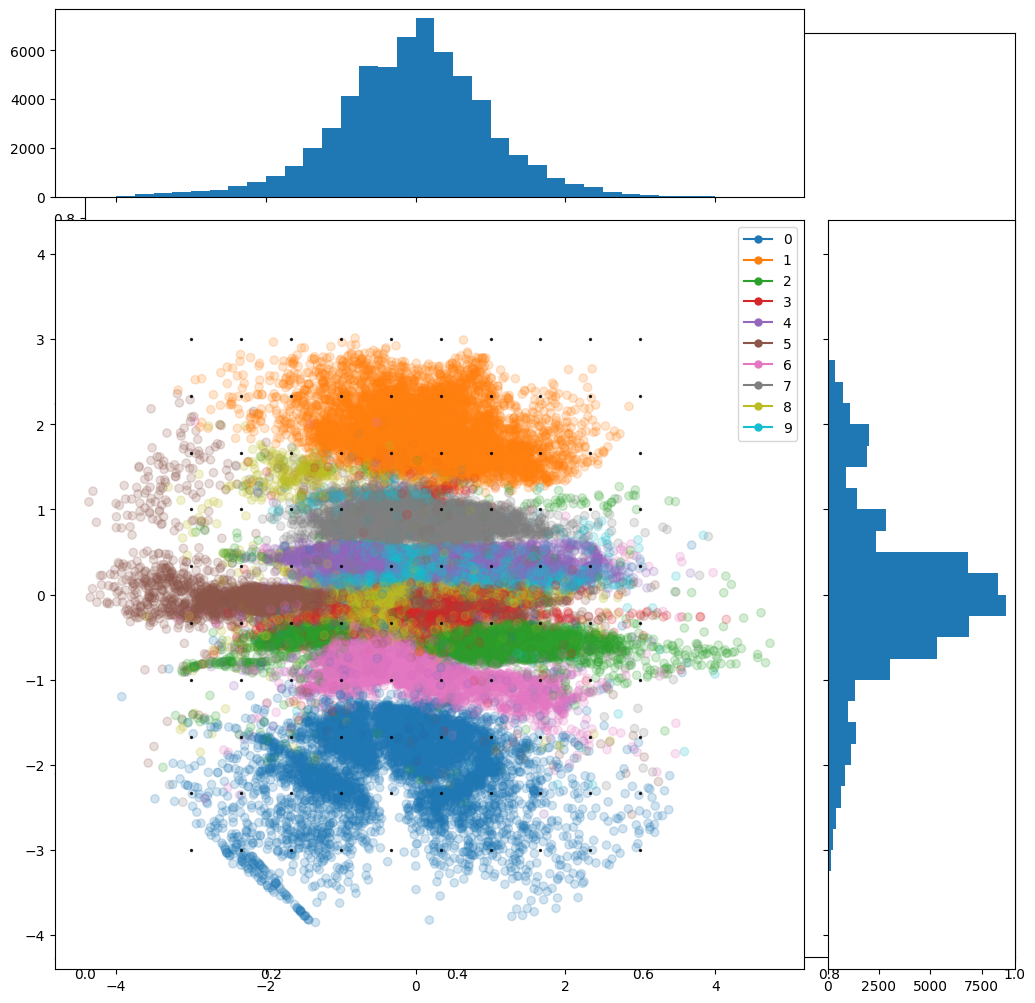

In [ ]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color=f'C{c}', label=f'{c}',
                    markerfacecolor=f'C{c}', markersize=5) for c in range(10)]

fig, ax = plt.subplots(figsize=(12, 12))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])

model.eval()
mu_x =[]
mu_y = []
for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
    mu, _ = model.encode(image.view(-1, 28*28).to(DEVICE))
    mu = mu.cpu().detach().numpy()

    mu_x.extend(mu[:, 0])
    mu_y.extend(mu[:, 1])

    label_cmap = [f'C{l}' for l in label]
    ax.scatter(mu[:, 0], mu[:, 1], c = label_cmap, alpha = 0.2)

ax.scatter(points[:, 0], points[:, 1], c='black', alpha=0.8, s=2)

plt.legend(handles = legend_elements)

ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

binwidth = 0.25
lim = 4
bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(mu_x, bins=bins)
ax_histy.hist(mu_y, bins=bins, orientation='horizontal')

plt.show()

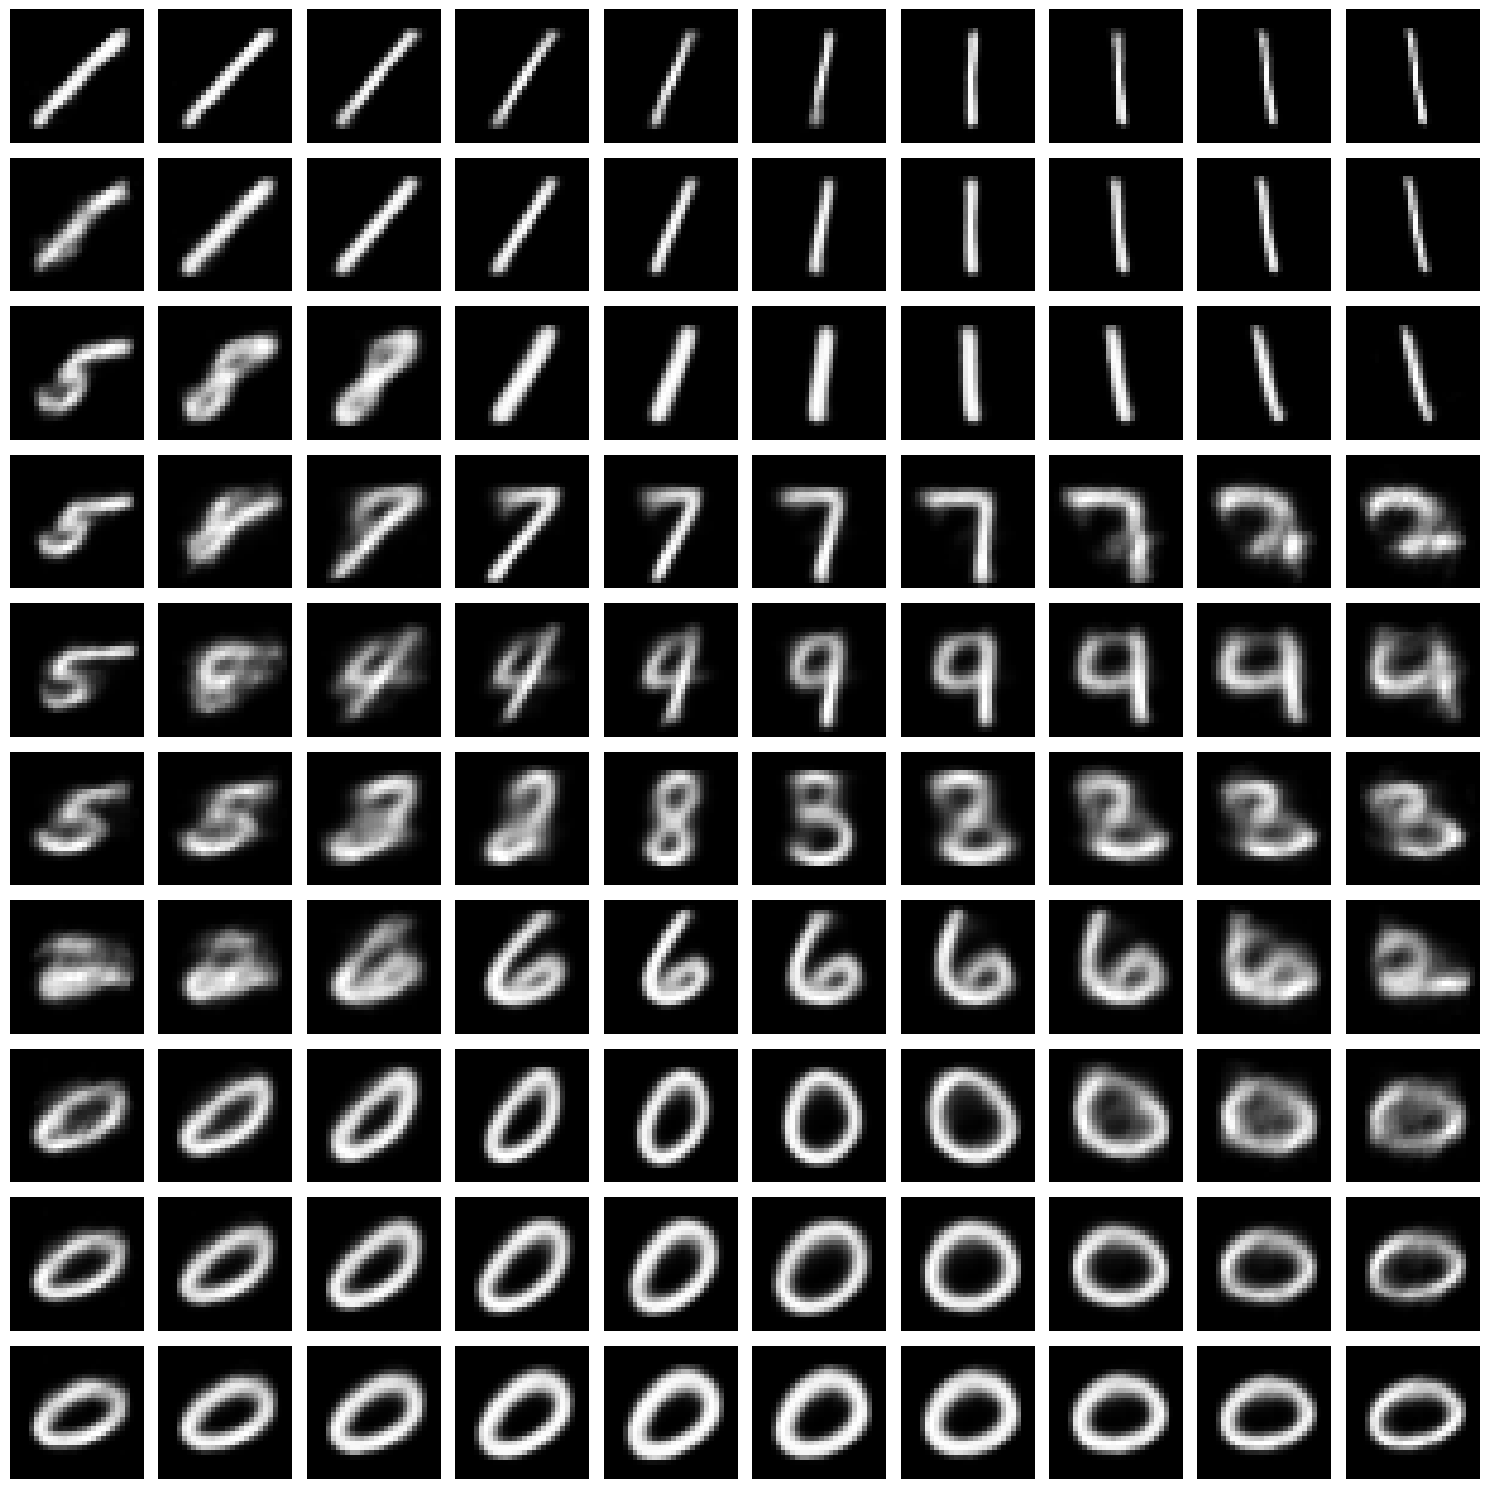

In [ ]:
num = 10
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))
x = np.linspace(-rng, rng, 10)  # x축 범위와 분할
y = np.linspace(-rng, rng, 10)  # y축 범위와 분할

# 2차원 이미지로 예제 그리기
for i in range(num):
    for j in range(num):
        point = [x[i], y[j]]
        out, _ = model.decode(torch.tensor(point, dtype=torch.float32).to(DEVICE))
        out = out.cpu().detach().numpy().reshape(28, 28)
        axes[num - j - 1, i].imshow(out, cmap='gray')
        axes[num - j - 1, i].axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()

1. 잠재 공간
    - VAE: VAE는 잠재 공간이 연속적이고 확률적 분포를 따르기 때문에, 이 공간에서의 샘플링이 매우 자연스럽습니다.     
    이는 데이터의 다양성을 잘 유지하면서 새로운 샘플을 생성할 수 있도록 합니다. 잠재 공간을 통해 의미 있는 __보간(interpolation)__ 을 할 수 있습니다.
    - GAN: GAN은 잠재 공간을 랜덤 벡터로 처리하며, 이 벡터가 어떤 구조를 가진 확률 분포에서 나온 것은 아닙니다.    
    따라서 잠재 공간의 의미가 명확하지 않으며, 데이터 간의 자연스러운 보간이 어려울 수 있습니다.
1. 생성된 데이터 품질
    - VAE: VAE는 생성된 데이터가 다소 흐릿하거나 디테일이 부족할 수 있습니다. 이는 모델이 평균적으로 데이터를 생성하려고 하다 보니, 고해상도나 세밀한 부분에서 손실이 발생할 수 있기 때문입니다.
    - GAN: GAN은 생성된 데이터의 디테일이 매우 좋습니다. GAN은 판별자와의 경쟁을 통해 고해상도의 이미지를 생성할 수 있으며,     
    매우 사실적인 데이터를 생성하는 데 강점이 있습니다. 특히, GAN은 사람 눈으로 보기에 매우 그럴듯한 데이터를 생성할 수 있습니다.
1. 학습 안정성
    - VAE: VAE는 상대적으로 학습이 안정적입니다. 손실 함수가 명확하게 정의되어 있고, 인코더-디코더 구조로 구성되어 있어 학습 과정이 비교적 간단합니다.      
    따라서 학습 실패나 불안정성 문제가 상대적으로 적습니다.
    - GAN: GAN은 학습이 불안정할 수 있습니다. 생성자와 판별자 간의 균형을 맞추는 것이 매우 중요하지만, 이 균형이 깨지면 학습이 어려워지거나 __모드 붕괴(mode collapse)__ 와 같은 문제가 발생할 수 있습니다. 모드 붕괴는 생성자가 매우 제한된 종류의 데이터를 반복적으로 생성하는 문제입니다.
1. 해석 가능성
    - VAE: VAE는 확률적 모델이기 때문에, 잠재 공간의 각 차원이나 데이터 간의 관계를 더 해석 가능하게 만듭니다.    
    잠재 공간에서의 움직임이 데이터를 어떻게 변형시키는지 파악할 수 있어, 보간과 데이터 변형에서 유리합니다.
    - GAN: GAN은 잠재 공간이 명확하지 않고, 모델이 왜 특정 데이터를 생성하는지 이해하기 어려운 블랙박스 성질을 가집니다. 따라서 해석 가능성이 낮은 편입니다.

## 생성모델 심화  
AAE (Adversarial Autoencoder)

AAE는 __VAE__의 잠재 공간에서의 확률 분포 학습 개념을 차용하면서, __GAN__의 적대적 학습(adversarial learning) 방식을 사용하여 더 정교한 데이터를 생성합니다.

- __잠재 공간에서의 확률 분포 학습__: AAE는 VAE처럼 잠재 공간을 확률 분포로 학습합니다. 하지만, 이를 위해 KL 발산 대신 GAN의 적대적 학습 방식을 사용하여, 판별기가 잠재 벡터가 가우시안 분포를 따르도록 학습합니다.

- __생성된 데이터의 품질__: GAN의 특성을 결합함으로써 AAE는 더 고품질의 데이터를 생성할 수 있습니다. 이는 VAE의 생성된 데이터 품질 문제를 보완하는 역할을 합니다.

- __학습 안정성__: GAN에 비해 학습이 안정적이며, 잠재 공간이 더 해석 가능하게 유지됩니다.


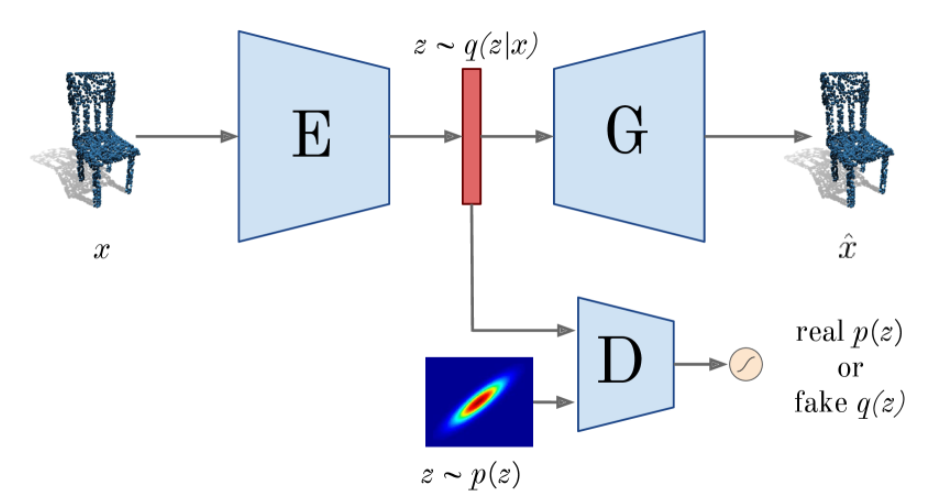

https://github.com/hwalsuklee/tensorflow-mnist-AAE

In [ ]:
import argparse
import os
import numpy as np
import math
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision import datasets

cuda = torch.cuda.is_available()
channels = 1
img_size = 28
latent_dim = 2
img_shape = (channels, img_size, img_size)
Tensor = torch.cuda.FloatTensor

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 128)
        )

        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mu, logvar)
        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Sigmoid(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], *img_shape)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

In [ ]:
from torchvision import transforms, datasets
BATCH_SIZE = 512
train_dataset = datasets.MNIST(root = "./data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "./data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11339611.74it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 345773.99it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2776838.57it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8474434.51it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [ ]:
#######################################################
# Preparation part
#######################################################

# define model
# 1) generator
encoder = Encoder()
decoder = Decoder()

# 2) discriminator
discriminator = Discriminator()

# loss
adversarial_loss = nn.BCELoss()
reconstruction_loss = nn.MSELoss()

lr = 0.001
b1 = 0.5
b2 = 0.999

# optimizer
optimizer_G = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

encoder.cuda()
decoder.cuda()
discriminator.cuda()
adversarial_loss.cuda()
reconstruction_loss.cuda()


#######################################################
# Training part
#######################################################

def sample_image(n_row, epoch, img_dir):
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    z = Variable(Tensor(np.random.normal(0,1,(n_row**2, latent_dim))))
    generated_imgs = decoder(z)
    save_image(generated_imgs.data, os.path.join(img_dir, "%depoch.png" % epoch), nrow = n_row, normalize = True)

n_epochs = 200

# training phase
from tqdm import tqdm
for epoch in range(n_epochs):
    for i, (x, idx) in enumerate(tqdm(train_loader)):

        valid = Variable(Tensor(x.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(x.shape[0], 1).fill_(0.0), requires_grad=False)

        x = x.cuda()

        # 1) reconstruction + generator loss
        optimizer_G.zero_grad()
        fake_z = encoder(x)
        decoded_x = decoder(fake_z)
        validity_fake_z = discriminator(fake_z)
        G_loss = 0.01*adversarial_loss(validity_fake_z, valid) + 0.99*reconstruction_loss(decoded_x, x)
        G_loss.backward()
        optimizer_G.step()

        # 2) discriminator loss
        optimizer_D.zero_grad()
        real_z = Variable(Tensor(np.random.normal(0,1,(x.shape[0], latent_dim))))
        real_loss = adversarial_loss(discriminator(real_z), valid)
        fake_loss = adversarial_loss(discriminator(fake_z.detach()), fake)
        D_loss = 0.5*(real_loss + fake_loss)
        D_loss.backward()
        optimizer_D.step()

    # print loss
    print(
            "[Epoch %d/%d] [G loss: %f] [D loss: %f]"
            % (epoch, n_epochs, G_loss.item(), D_loss.item())
         )

    if epoch % 5 == 0:
        sample_image(n_row = 10, epoch=epoch, img_dir='aae_results/')